### Import libraries and functions

In [1]:
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain

from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import LabelPowerset

#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss

from collections import Counter
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
wnl = WordNetLemmatizer()
wpt = WordPunctTokenizer()
p_stem = PorterStemmer()

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Load training dataset and testing dataset into dataframes

In [18]:
# Load downloaded training dataset to dataframe
df_train = pd.read_csv('train.csv')

# Load downloaded testing dataset to dataframes
df_test_work = pd.read_csv('test.csv')
df_testlabel_work = pd.read_csv('test_labels.csv')

# Remove downloaded testing data that were not labeled
df_test = df_test_work.drop(df_testlabel_work[df_testlabel_work['toxic'] ==-1].index.values)
df_testlabel = df_testlabel_work[df_testlabel_work['toxic'] !=-1]

# Combined downloaded testing comments and testing labels
df_test_full = df_test.merge(df_testlabel)

# Combined downloaded training and testing data into one full data set
df = df_train.append(df_test_full)

In [20]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [21]:
df.shape

(223549, 8)

### Explore training dataset

In [22]:
print('Total # of comments = ', df.shape[0])

df_explore = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_explore.columns.values)

for i in categories:
    counts.append([i, df_explore[i].sum()])
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

Total # of comments =  223549


,category,number_of_comments
0,toxic,21384
1,severe_toxic,1962
2,obscene,12140
3,threat,689
4,insult,11304
5,identity_hate,2117


Text(0.5,0,'category')

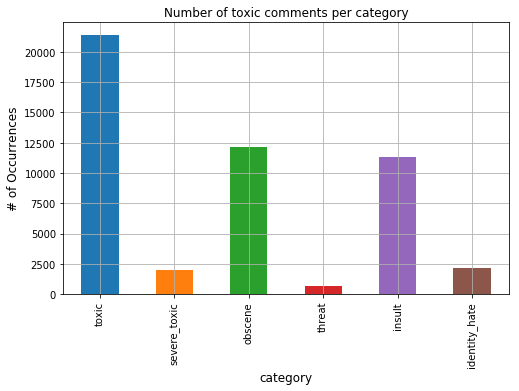

In [96]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of toxic comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [23]:
num_clean = []
num_label = []

for label in categories:
    num_clean.append(df_explore[label].value_counts()[0])
    num_label.append(df_explore[label].value_counts()[1])

print(f"Number of clean comments for each label: {num_clean}" )
print(f"Number of offensive comments for each label: {num_label}" )
print(f"Ratio of clean comments for each label: {(np.array(num_clean)/(np.array(num_clean) + np.array(num_label)))}" )


Number of clean comments for each label: [202165, 221587, 211409, 222860, 212245, 221432]
Number of offensive comments for each label: [21384, 1962, 12140, 689, 11304, 2117]
Ratio of clean comments for each label: [0.90434312 0.9912234  0.94569423 0.9969179  0.9494339  0.99053004]


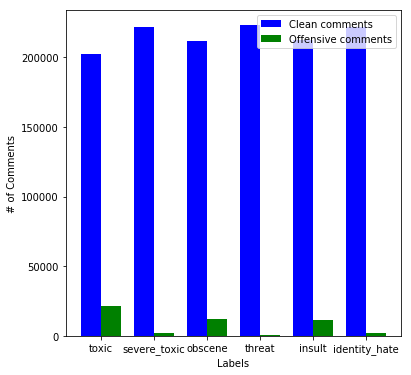

In [24]:
x_graph = list(df.columns[2:])
fig = plt.figure(figsize=(6,6))
X_bar = np.arange(6)
plt.bar(X_bar-0.375/2, num_clean, color = 'b', width = 0.375, label='Clean comments')
plt.bar(X_bar+0.375/2, num_label, color = 'g', width = 0.375, label='Offensive comments')
plt.xticks(X_bar,x_graph)
plt.xlabel('Labels')
plt.ylabel('# of Comments')
plt.legend(loc='upper right')
plt.show()

### Clean training dataset

In [25]:
def clean_text(text):
    
    # convert all text to lower case
    text = text.lower()
    
    # convert contractions back to long form
    text = re.sub("what's", "what is ", text)
    text = re.sub("\'s", " ", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not ", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'scuse", " excuse ", text)
    
    # remove non-alphabet and non-numbers
    text = re.sub('\W', ' ', text)

    # remove multi-space
    text = re.sub('\s+', ' ', text)
    
    # remove leading and trailing spaces
    text.strip(' ')
    
    return text

In [26]:
test_clean_text1 = df.iloc[38074].comment_text
test_clean_text1

'"====Regarding edits made during August 9 2006 (UTC) to Oprah Winfrey====\nPlease do not replace Wikipedia pages or sections with blank content. It is considered vandalism. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia. Thanks.  If this is an IP address, and it is shared by multiple users, ignore this warning if you did not make any unconstructive edits.  don\'t talk email me "'

In [27]:
clean_text(test_clean_text1)

' regarding edits made during august 9 2006 utc to oprah winfrey please do not replace wikipedia pages or sections with blank content it is considered vandalism please use the sandbox for any other tests you want to do take a look at the welcome page if you would like to learn more about contributing to our encyclopedia thanks if this is an ip address and it is shared by multiple users ignore this warning if you did not make any unconstructive edits do not talk email me '

In [28]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

In [29]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can not make any real suggestions on i...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


### Explore most frequent offensive words in each category

In [30]:
train, test = train_test_split(df, random_state=424, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(149777,)
(73772,)


In [34]:
total = train.toxic + train.severe_toxic + train.obscene + train.threat + train.insult + train.identity_hate

In [35]:
train['total'] = total

C:\Users\King Wong\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total
19351,33192c3922d45121,i only called out one example but could call o...,0,0,0,0,0,0,0
37279,94c83e72c60dafd8,for halloween you should ttly go as a stripper...,1,0,0,0,0,0,1
125160,9d69d125776989e1,thank you for you insult now do you think you ...,0,0,0,0,0,0,0
34755,5cd3dfd2d4819b56,provide sources for all statements non asu so...,0,0,0,0,0,0,0
55982,df844c8e84128ea6,support per guettarda especially below since ...,0,0,0,0,0,0,0


In [37]:
train.shape

(149777, 9)

In [38]:
df_neutral = train[train.total==0]

neutral_list = []

for num in range(len(df_neutral.comment_text)):

    place_holder = []

    for word in wpt.tokenize(df_neutral.comment_text.iloc[num]):

        place_holder.append(word)

        if len(place_holder) == 1:
            phrase = " ".join(place_holder)  

            neutral_list.append(phrase)            

            del place_holder[0]

neutral_list_unique = []

for pair in list(Counter(neutral_list).most_common(1000)):
    neutral_list_unique.append(pair[0])

In [39]:
def wordcount(dataframe, name):
    
    global_list_cnt = []

    for num in range(len(dataframe.comment_text)):

        place_holder = []
        local_list_cnt = []

        for word in wpt.tokenize(dataframe.comment_text.iloc[num]):

            word_low = word.lower()

            # Taking out the neutral words (only for 1-word count)
            if word_low not in neutral_list_unique:

                place_holder.append(word_low)

                if len(place_holder) == 1:
                    phrase = " ".join(place_holder)  

                    if phrase not in local_list_cnt:
                        local_list_cnt.append(phrase)

                    del place_holder[0]     

        global_list_cnt.extend(local_list_cnt)

    list_cnt = Counter(global_list_cnt)
    
    df_wcnt = pd.DataFrame.from_dict(dict(list_cnt),orient='index',columns=['count'])
    df_wcnt['% of Total'] = round(df_wcnt['count'] / df_wcnt['count'].sum() * 100,2)

    rank = []
    for num in range(20):
        rank.append(num+1)    
   
    df_wcnt = df_wcnt.sort_values('count',ascending=False).head(20).reset_index()
    df_wcnt['rank']=rank
    df_wcnt_ranked = df_wcnt.set_index('rank')
    df_wcnt_ranked = df_wcnt_ranked.rename(columns={"index": name})    
    
    return df_wcnt_ranked   

In [40]:
word_count_toxic = wordcount(train[train.toxic==1],'toxic')
word_count_severe_toxic = wordcount(train[train.severe_toxic==1],'severe_toxic')
word_count_obscene = wordcount(train[train.obscene==1],'obscene')
word_count_threat = wordcount(train[train.threat==1],'threat')
word_count_insult = wordcount(train[train.insult==1],'insult')
word_count_identity_hate = wordcount(train[train.identity_hate==1],'identity_hate')

In [41]:
master_list_wc = pd.concat([word_count_toxic, word_count_severe_toxic,word_count_obscene,word_count_threat,word_count_insult,word_count_identity_hate],axis=1)
master_list_wc

,toxic,count,% of Total,severe_toxic,count,% of Total,obscene,count,% of Total,threat,count,% of Total,insult,count,% of Total,identity_hate,count,% of Total
rank,,,,,,,,,,,,,,,,,,
1,fuck,2201,1.63,fuck,575,4.47,fuck,2132,2.83,kill,137,3.00,fuck,1655,2.39,fuck,267,1.83
2,fucking,1479,1.09,fucking,351,2.73,fucking,1410,1.87,die,87,1.91,fucking,1123,1.62,fucking,214,1.47
3,shit,1159,0.86,shit,229,1.78,shit,1033,1.37,fuck,81,1.78,shit,760,1.10,faggot,161,1.11
4,stupid,1070,0.79,bitch,209,1.62,ass,749,1.00,fucking,79,1.73,stupid,702,1.01,shit,136,0.93
5,ass,840,0.62,ass,193,1.50,bitch,674,0.90,ass,55,1.21,bitch,623,0.90,nigger,131,0.90
6,bitch,680,0.50,suck,148,1.15,stupid,558,0.74,shit,47,1.03,ass,600,0.86,ass,131,0.90
7,suck,624,0.46,dick,131,1.02,suck,536,0.71,bitch,41,0.90,idiot,455,0.66,bitch,111,0.76
8,idiot,560,0.41,asshole,115,0.89,asshole,459,0.61,hell,34,0.75,suck,437,0.63,stupid,89,0.61
9,hell,540,0.40,cunt,101,0.78,dick,457,0.61,rape,29,0.64,asshole,421,0.61,dick,67,0.46


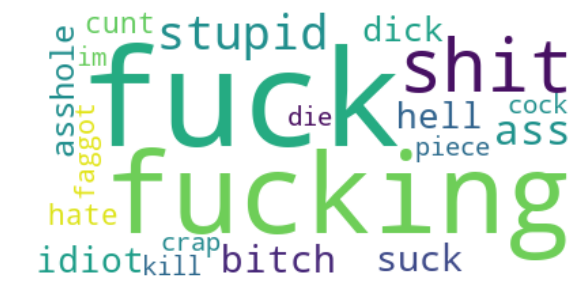

In [42]:
new_dict_toxic ={}

for num in range(20):
    
    new_dict_toxic[word_count_toxic.iloc[num].toxic] = word_count_toxic.iloc[num]['count']
    
wordcloud = WordCloud(max_font_size=100,background_color='white').fit_words(new_dict_toxic)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

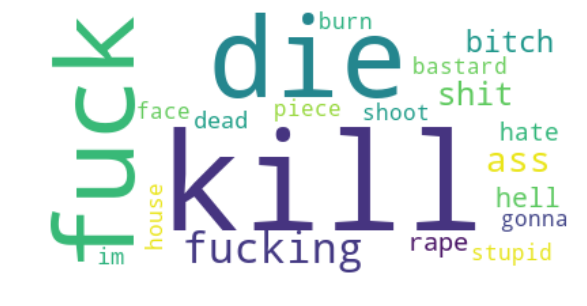

In [44]:
new_dict_threat ={}

for num in range(20):
    
    new_dict_threat[word_count_threat.iloc[num].threat] = word_count_threat.iloc[num]['count']
    
wordcloud = WordCloud(max_font_size=100,background_color='white').fit_words(new_dict_threat)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

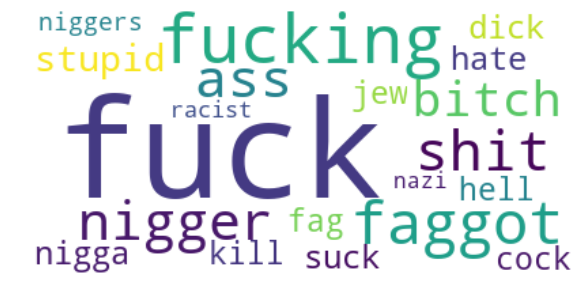

In [43]:
new_dict_identity_hate ={}

for num in range(20):
    
    new_dict_identity_hate[word_count_identity_hate.iloc[num].identity_hate] = word_count_identity_hate.iloc[num]['count']
    
wordcloud = WordCloud(max_font_size=100,background_color='white').fit_words(new_dict_identity_hate)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Baseline results if one guesses all clean comments (all 0s)

In [57]:
prediction_baseline = np.zeros((X_test.shape[0], 6))

print('Accuracy if one guesses all clean comments = {:.2%}'.format(accuracy_score(test[categories].values, prediction_baseline)))

Accuracy if one guesses all clean comments = 89.82%


In [58]:
print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction_baseline[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction_baseline[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction_baseline[:,count_n])))

    count_n +=1

For individual labels:


C:\Users\King Wong\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


	 toxic:
	 accuracy= 90.32%
	 precision = nan%
	 recall = 0.00%
	 f1 score = nan%
	 hamming_loss = 9.68%

	 severe_toxic:
	 accuracy= 99.11%
	 precision = nan%
	 recall = 0.00%
	 f1 score = nan%
	 hamming_loss = 0.89%

	 obscene:
	 accuracy= 94.50%
	 precision = nan%
	 recall = 0.00%
	 f1 score = nan%
	 hamming_loss = 5.50%

	 threat:
	 accuracy= 99.67%
	 precision = nan%
	 recall = 0.00%
	 f1 score = nan%
	 hamming_loss = 0.33%

	 insult:
	 accuracy= 94.93%
	 precision = nan%
	 recall = 0.00%
	 f1 score = nan%
	 hamming_loss = 5.07%

	 identity_hate:
	 accuracy= 99.03%
	 precision = nan%
	 recall = 0.00%
	 f1 score = nan%
	 hamming_loss = 0.97%



## Multinomial Naive Bayes model w/ CountVectorizer

In [85]:
NB_pipeline_t = Pipeline([
                    ('vect', CountVectorizer(min_df=1, ngram_range=(1, 1),stop_words='english')),
                    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))])

NB_pipeline_t.fit(X_train, train[categories].values)

prediction_NB = NB_pipeline_t.predict(X_test)   

In [91]:
print('For all (6) labels:')
print('\t accuracy = {:.2%}'.format(accuracy_score(test[categories].values, prediction_NB)))
print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[categories].values, prediction_NB)))

print('For individual labels:')

conf_mat = {}
count_n = 0

for category in categories:
    
    conf_mat[category] = confusion_matrix(test[category], prediction_NB[:,count_n])
    tn,fp,fn,tp = conf_mat[category].ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)      
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print('\t {}:'.format(category))
    print('\t accuracy= {:.2%}'.format(accuracy_score(test[category].values, prediction_NB[:,count_n])))
    print('\t precision = {:.2%}'.format(precision))
    print('\t recall = {:.2%}'.format(recall))
    print('\t f1 score = {:.2%}'.format(f1))
    print('\t hamming_loss = {:.2%}\n'.format(hamming_loss(test[category].values, prediction_NB[:,count_n])))

    count_n +=1

For all (6) labels:
	 accuracy = 89.95%
	 hamming_loss = 2.82%

For individual labels:
	 toxic:
	 accuracy= 94.00%
	 precision = 75.44%
	 recall = 56.29%
	 f1 score = 64.47%
	 hamming_loss = 6.00%

	 severe_toxic:
	 accuracy= 98.73%
	 precision = 32.23%
	 recall = 38.51%
	 f1 score = 35.09%
	 hamming_loss = 1.27%

	 obscene:
	 accuracy= 96.27%
	 precision = 71.03%
	 recall = 54.35%
	 f1 score = 61.58%
	 hamming_loss = 3.73%

	 threat:
	 accuracy= 99.44%
	 precision = 4.32%
	 recall = 3.25%
	 f1 score = 3.71%
	 hamming_loss = 0.56%

	 insult:
	 accuracy= 95.90%
	 precision = 62.52%
	 recall = 47.69%
	 f1 score = 54.11%
	 hamming_loss = 4.10%

	 identity_hate:
	 accuracy= 98.76%
	 precision = 26.84%
	 recall = 15.76%
	 f1 score = 19.86%
	 hamming_loss = 1.24%



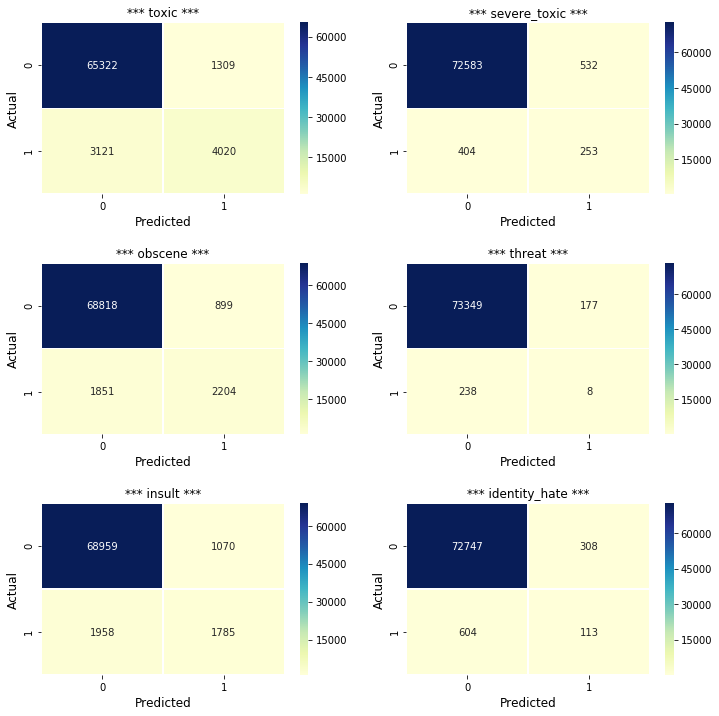

In [92]:
plt.rcParams['figure.figsize'] = [12, 12]
cf=1
for category in categories:
    plt.subplot(3,2,cf)
    plt.subplots_adjust(hspace=0.4)
    sns.heatmap(conf_mat[category],annot=True, fmt='d', linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.title(f'*** {category} ***')
    cf+=1